<h2>Import libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import glob
from datetime import datetime
import time
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error,median_absolute_error,mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
import matplotlib.pyplot as plt
from itertools import permutations
import numpy as np
from itertools import combinations 
%matplotlib inline
import xgboost as xg

import seaborn as sns
sns.set()
import numpy

<h2> Load and split dataset </h2>

In [2]:
merged = pd.read_csv('state_with_real_numbers.csv')
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7178 entries, 0 to 7177
Data columns (total 41 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   date                                                 7178 non-null   object 
 1   state_code                                           7178 non-null   object 
 2   gender                                               7178 non-null   object 
 3   age_bucket                                           7178 non-null   object 
 4   pct_hh_cli_weighted                                  7178 non-null   float64
 5   pct_cmnty_cli_weighted                               7178 non-null   float64
 6   pct_hh_fever_weighted                                7178 non-null   float64
 7   pct_hh_sore_throat_weighted                          7178 non-null   float64
 8   pct_hh_cough_weighted                                7178 non-null  

In [3]:
features = ['pct_cmnty_cli_weighted', 'pct_self_anosmia_ageusia_weighted', 'pct_hh_cli_weighted', 'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted', 'pct_hh_difficulty_breathing_weighted', 'pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted', 'pct_worked_outside_home_weighted', 'pct_self_nausea_vomiting_weighted', 'pct_hh_shortness_of_breath_weighted', 'pct_self_sore_throat_weighted', 'pct_self_difficulty_breathing_weighted', 'pct_asthma_weighted', 'pct_self_shortness_of_breath_weighted', 'pct_hh_cough_weighted', 'pct_self_none_of_above_weighted', 'pct_self_diarrhea_weighted', 'pct_chronic_lung_disease_weighted', 'pct_cancer_weighted', 'pct_self_other_weighted', 'pct_self_tiredness_or_exhaustion_weighted', 'pct_self_cough_weighted', 'pct_no_above_medical_conditions_weighted', 'pct_heart_disease_weighted', 'pct_multiple_medical_conditions_weighted', 'pct_autoimmune_disorder_weighted', 'pct_self_nasal_congestion_weighted', 'pct_kidney_disease_weighted',  'pct_self_multiple_symptoms_weighted', 'pct_self_muscle_joint_aches_weighted', 'pct_high_blood_pressure_weighted', 'pct_diabetes_weighted',  ]
len(features)

35

In [4]:
merged = merged.sort_values(by='date', ascending=True)
X_train = merged[:len(merged)*80//100]
X_test = merged[len(merged)*80//100:]
X_train = X_train.sample(frac=1)
y_train = X_train['daily_case']
X_test = X_test.sample(frac=1)
y_test = X_test['daily_case']
print(len(X_train), len(y_test))

5742 1436


<h2>Feature ranking </h2>

In [6]:
features_ranked=[]
features_copy=features.copy()
i = 1
for fr in (features):
    X_reg_new = SelectKBest(score_func=f_regression, k=1).fit_transform(merged[features_copy],merged['daily_case'])
    to_comp = np.squeeze(X_reg_new)
    cols = features
    for c in cols:
        cur_col=np.array(merged[c])
        if np.allclose(to_comp,cur_col):
            selected_feature=c
            features_ranked.append(selected_feature)
            print(i,selected_feature)
            features_copy.remove(selected_feature)
            break
    i +=1

1 pct_cmnty_cli_weighted
2 pct_self_anosmia_ageusia_weighted
3 pct_hh_fever_weighted
4 pct_hh_cli_weighted
5 pct_hh_sore_throat_weighted
6 pct_self_fever_weighted
7 pct_asthma_weighted
8 pct_autoimmune_disorder_weighted
9 pct_self_runny_nose_weighted
10 pct_self_sore_throat_weighted
11 pct_avoid_contact_all_or_most_time_weighted
12 pct_self_none_of_above_weighted
13 pct_self_muscle_joint_aches_weighted
14 pct_self_persistent_pain_pressure_in_chest_weighted
15 pct_chronic_lung_disease_weighted
16 pct_no_above_medical_conditions_weighted
17 pct_self_nasal_congestion_weighted
18 pct_self_multiple_symptoms_weighted
19 pct_cancer_weighted
20 pct_self_nausea_vomiting_weighted
21 pct_multiple_medical_conditions_weighted
22 pct_heart_disease_weighted
23 pct_self_tiredness_or_exhaustion_weighted
24 pct_diabetes_weighted
25 pct_hh_difficulty_breathing_weighted
26 pct_self_other_weighted
27 pct_worked_outside_home_weighted
28 pct_hh_shortness_of_breath_weighted
29 pct_hh_cough_weighted
30 pct_sel

<h2> error metrics </h2>

In [7]:
def get_mae (y_pred, y_true):
    abs_sum = 0
    for j in range(len(y_pred)):
        diff=abs(y_pred[j]-y_true[j])
        abs_sum += diff
    abs_error = abs_sum/len(y_pred)
    return abs_error

def get_nmae (y_pred, y_true):
    abs_sum = 0
    for j in range(len(y_pred)):
        diff=abs(y_pred[j]-y_true[j])
        abs_sum += diff
    n_abs_error = abs_sum/sum(y_true)
    return n_abs_error

def get_mre (y_pred, y_true):
    rel_sum = 0
    for j in range(len(y_pred)):
        diff= y_pred[j]-y_true[j]
        rel = diff/(y_true[j] +1)
        rel_sum += abs(rel)
    rel_error = rel_sum/len(y_pred)
    return rel_error*100

<h2>error vs number of features </h2>
please note that the exact results of this code might vary slightly with the results reported in the paper due to random seed 

In [35]:
xgb_rel_errors=[]
xgb_abs_errors=[]
xgb_n_abs_errors=[]
for i in range(1,len(features_ranked)+1):
    reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05)
    reg = reg.fit(X_train[features_ranked[:i]],y_train)
    y_pred= reg.predict(X_test[features_ranked[:i]])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    xgb_rel_errors.append(mre)
    xgb_abs_errors.append(mae)
    xgb_n_abs_errors.append(nmae)
    print(i,mae,nmae,mre)

1 839.6506985422628 1.0047033008303428 1154.311443622431


D:\anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


2 821.5805840941774 0.9830810909472414 1216.8416709232397
3 739.2310843112201 0.8845439082862777 744.2193166830177
4 691.9488556528656 0.8279672731615315 778.2804171781036
5 688.7651734600327 0.8241577652155638 670.9023678816077
6 665.4568860795489 0.7962676993720761 614.1107746695759
7 666.2407178478238 0.7972056112516811 590.2444361780183
8 646.2129016509047 0.773240868440888 563.1220477134434
9 629.4675938049564 0.7532038862821725 686.9655920655018
10 613.2754988890754 0.7338288637429337 696.3070977088529
11 509.78219264322337 0.609991574523053 435.2306846882649
12 503.8587755154932 0.6029037739045844 489.29297575227554
13 492.57384799209143 0.5894005350552901 449.3337209487181
14 496.24071002481793 0.59378820292047 404.0135105403575
15 483.61735168390993 0.5786834339794171 459.2350638495364
16 471.1548690877253 0.5637711646004175 459.52852763918185
17 470.9813566814724 0.5635635443511878 398.82843047239857
18 462.8654464665894 0.5538522658441941 467.59952919938206
19 468.3598424508

In [75]:
gb_rel_errors=[]
gb_abs_errors=[]
gb_n_abs_errors=[]
for i in range(1,len(features_ranked)+1):
    reg = GradientBoostingRegressor()
    reg = reg.fit(X_train[features_ranked[:i]],y_train)
    y_pred= reg.predict(X_test[features_ranked[:i]])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    gb_rel_errors.append(mre)
    gb_abs_errors.append(mae)
    gb_n_abs_errors.append(nmae)
    print(i,mae,nmae,mre)    

1 825.5017767380015 0.9877730839382333 1149.8146897411316
2 770.5943462967441 0.9220723387352362 967.1594331965543
3 728.5938905578142 0.8718157301353239 938.4627771004842
4 717.8846192130845 0.8590013058893632 898.5819157360924
5 710.4974348361421 0.850162000997172 808.6071040413442
6 700.837374027932 0.8386030336824535 709.6728514557517
7 691.7236478221703 0.8276977955665444 713.1812024578674
8 685.1965276466905 0.819887620220289 681.8651829864167
9 678.0760771372329 0.8113674818548101 840.4557411256926
10 674.3452908390333 0.8069033239436676 883.8960410349571
11 546.5058846410775 0.6539341504453712 557.1211777678694
12 534.5123126434273 0.639582966797569 560.7395427678524
13 538.1566372479915 0.6439436669861826 642.5578324991883
14 531.9857022817661 0.6365596932212111 609.7426789688309
15 522.3178078718481 0.6249913524307045 583.6431913171369
16 518.8582956888177 0.6208517937837721 619.4428396775604
17 520.2269235367547 0.6224894568248651 572.682408079054
18 518.0328969230524 0.6198

In [37]:
lr_rel_errors=[]
lr_abs_errors=[]
lr_n_abs_errors=[]
for i in range(1,len(features_ranked)+1):
    reg = LinearRegression()
    reg = reg.fit(X_train[features_ranked[:i]],y_train)
    y_pred= reg.predict(X_test[features_ranked[:i]])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    lr_rel_errors.append(mre)
    lr_abs_errors.append(mae)
    lr_n_abs_errors.append(nmae)
    print(i,mae,nmae,mre)   

1 804.9402683320102 0.9631697394743801 1197.0765128369715
2 805.8390808862466 0.9642452342505256 1243.2468685259153
3 811.3845806307964 0.9708808291565691 1304.135172314348
4 811.8160154267578 0.9713970723566855 1308.7800877706013
5 814.5592688385102 0.9746795751433642 1375.7636067488522
6 812.8806368550705 0.9726709695439535 1362.8503061164552
7 807.2112794978661 0.9658871699707988 1359.9227830456077
8 813.7149065310597 0.9736692340588335 1450.8987192129853
9 826.5974429726683 0.9890841285005606 1554.6557242620488
10 825.5097281869024 0.9877825984267832 1532.3038105151752
11 790.8188169669562 0.9462723929663419 1566.5932095532605
12 800.3030520728621 0.9576209720043846 1739.2249821858275
13 797.6490319854687 0.9544452433985448 1744.1275643339718
14 798.0062709217685 0.9548727058410921 1745.9198815718305
15 799.0261901081318 0.9560931135355041 1758.1464266330581
16 801.6802163092345 0.9592688494568433 1762.3410278858792
17 797.9514739464196 0.9548071372634632 1772.5318111574413
18 797.

In [38]:
dt_rel_errors=[]
dt_abs_errors=[]
dt_n_abs_errors=[]
for i in range(1,len(features_ranked)+1):
    reg = DecisionTreeRegressor()
    reg = reg.fit(X_train[features_ranked[:i]],y_train)
    y_pred= reg.predict(X_test[features_ranked[:i]])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    dt_rel_errors.append(mre)
    dt_abs_errors.append(mae)
    dt_n_abs_errors.append(nmae)
    print(i,mae,nmae,mre)   

1 1043.6201253481895 1.2487675965382712 1108.935130218824
2 985.9352367688023 1.1797434200987589 669.9520635831989
3 956.9979108635098 1.1451177991057366 1110.7613782446508
4 946.1044568245126 1.132082986832698 685.131847634139
5 883.5633704735376 1.0572480155721136 835.4406649543165
6 873.2694986072423 1.0449306470993105 765.9412648134762
7 895.5069637883008 1.0715393960806403 776.2607945499839
8 885.0271587743732 1.0589995450356389 709.4879775945566
9 892.783426183844 1.0682804846953655 1366.3260638601048
10 850.5313370473538 1.0177227783823601 1417.3425870522615
11 608.7722841225627 0.7284404388322915 554.8243575061715
12 611.1789693593315 0.7313202132499621 578.4968814108252
13 597.6559888579387 0.715138980779839 564.5714170090897
14 617.4798050139276 0.7388596226628914 546.5934194521338
15 627.6176880222841 0.7509903390901046 514.8580271337212
16 600.2541782729805 0.7182479039141934 512.2368993570784
17 605.6462395543175 0.7246998985079502 448.81833583168617
18 627.3488857938719 0

In [39]:
mlp_rel_errors=[]
mlp_abs_errors=[]
mlp_n_abs_errors=[]
for i in range(1,len(features_ranked)+1):
    reg = MLPRegressor((100,50), max_iter=1000)
    reg = reg.fit(X_train[features_ranked[:i]],y_train)
    y_pred= reg.predict(X_test[features_ranked[:i]])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    mlp_rel_errors.append(mre)
    mlp_abs_errors.append(mae)
    mlp_n_abs_errors.append(nmae)
    print(i,mae,nmae,mre)   

1 810.6548840989103 0.9700076940356632 1161.6358878695394
2 790.8214817491541 0.946275581572598 1136.375512387528
3 690.1194883763716 0.8257783017900845 817.4769583042658
4 676.6441837511783 0.8096541169830797 794.2809858089124
5 682.2472458921393 0.8163585894947496 705.391316645608
6 678.1250633407434 0.811426097420125 699.8992859156064
7 689.6004421962297 0.8251572251788492 838.5093013962779
8 652.8548650396191 0.7811884620678822 594.1153077537948
9 628.3889749905829 0.7519132402015818 677.2560064803463
10 653.1351031819885 0.7815237874444297 834.7662308225164
11 564.1782373425159 0.6750804093878087 788.6292192534643
12 598.503759872701 0.7161534006312829 453.21896071870685


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


13 588.1506519016356 0.7037651518387299 705.803122703402
14 549.9868209980639 0.6580993446790165 657.7778077439552
15 560.7888032654021 0.6710247043057606 662.8139178422662
16 546.2840136855169 0.6536686656648582 531.4332805146374
17 613.238328341541 0.7337843864717705 797.1580760763464
18 575.5731404929039 0.6887152420958775 782.991722407813
19 602.6281777065394 0.7210885673843804 624.2117258114588
20 562.1259226689298 0.6726246651950457 669.1547430983144
21 548.0392230582829 0.6557689016957791 753.9402678151108
22 639.279503669042 0.764944552067375 770.8175653252638
23 586.6734301382553 0.7019975482574987 634.2749470685864
24 612.9455228251697 0.7334340233156268 942.8398908189794
25 599.3688371486593 0.7171885286864819 726.6023475155616
26 561.496491780226 0.6718715052290942 854.1164949871343
27 563.912298371578 0.6747621940127907 1037.9173611581386
28 549.6333733546148 0.6576764187948835 798.2300966920582
29 542.7841182911277 0.6494807855601806 832.542130951371
30 557.8188963803501 

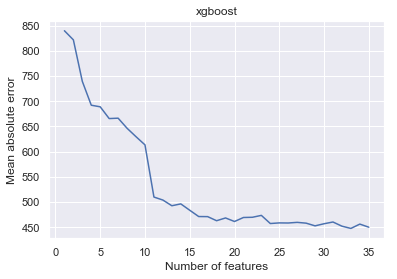

In [97]:
plt.plot(range(1,len(features_ranked)+1),xgb_abs_errors)
plt.xlabel('Number of features')
plt.ylabel('Mean absolute error')
plt.title('xgboost')
plt.show()

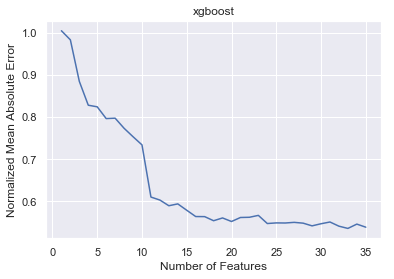

In [98]:
plt.plot(range(1,len(features_ranked)+1),xgb_n_abs_errors)
plt.xlabel('Number of Features')
plt.ylabel('Normalized Mean Absolute Error')
plt.title('xgboost')
plt.show()

<h2> mre vs daily cases </h2>

In [42]:
reg = GradientBoostingRegressor()
reg = reg.fit(X_train[features_ranked],y_train)
y_pred= reg.predict(X_test[features_ranked])
yp_l=list(y_pred)
yt_l=list(y_test)
pct_sm=0
abs_sum = 0
pct_count = 0
for j in range(len(y_pred)):
    diff=abs(yp_l[j]-yt_l[j])
    abs_sum += diff
    pct= diff/(yt_l[j]+1)
    #pct_sm+= pct
    if yt_l[j] > 150:
       # print(yp_l[j],yt_l[j], pct*100)
        pct_sm+= pct
        pct_count +=1 
print()
rel_error=pct_sm/pct_count
abs_error = abs_sum/len(y_pred)
print(i,abs_error,rel_error*100, pct_count)


35 502.55702986263617 62.80271478685905 1089


In [43]:
reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05)
reg = reg.fit(X_train[features_ranked],y_train)
y_pred= reg.predict(X_test[features_ranked])
yp_l=list(y_pred)
yt_l=list(y_test)
pct_sm=0
abs_sum = 0
pct_count = 0
for j in range(len(y_pred)):
    diff=abs(yp_l[j]-yt_l[j])
    abs_sum += diff
    pct= diff/(yt_l[j]+1)
    #pct_sm+= pct
    if yt_l[j] > 150:
       # print(yp_l[j],yt_l[j], pct*100)
        pct_sm+= pct
        pct_count +=1 
print()
rel_error=pct_sm/pct_count
abs_error = abs_sum/len(y_pred)
print(i,abs_error,rel_error*100, pct_count)


35 450.03936411556595 49.65116035483217 1089


D:\anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<h2> Most important global features </h2>

In [44]:
reg = GradientBoostingRegressor()
reg = reg.fit(X_train[features_ranked],y_train)
for i in range(len(features_ranked)):
    print ('global gdbt',features_ranked[i], list(reg.feature_importances_)[i] )

global gdbt pct_cmnty_cli_weighted 0.24279134738350985
global gdbt pct_self_anosmia_ageusia_weighted 0.02799137965178346
global gdbt pct_hh_fever_weighted 0.008864972439876509
global gdbt pct_hh_cli_weighted 0.008338545920196226
global gdbt pct_hh_sore_throat_weighted 0.01347782775984682
global gdbt pct_self_fever_weighted 0.005106168582290201
global gdbt pct_asthma_weighted 0.00725685369109223
global gdbt pct_autoimmune_disorder_weighted 0.014039518811556805
global gdbt pct_self_runny_nose_weighted 0.05563226297090317
global gdbt pct_self_sore_throat_weighted 0.0052945398993197255
global gdbt pct_avoid_contact_all_or_most_time_weighted 0.3164417614690507
global gdbt pct_self_none_of_above_weighted 0.05501662312719128
global gdbt pct_self_muscle_joint_aches_weighted 0.011304374337720845
global gdbt pct_self_persistent_pain_pressure_in_chest_weighted 0.005562949381844741
global gdbt pct_chronic_lung_disease_weighted 0.0016760152790766222
global gdbt pct_no_above_medical_conditions_weigh

In [45]:
reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05)
reg = reg.fit(X_train[features_ranked],y_train)
for i in range(len(features_ranked)):
    print ('global xgb',features_ranked[i], list(reg.feature_importances_)[i] )

global xgb pct_cmnty_cli_weighted 0.12272348
global xgb pct_self_anosmia_ageusia_weighted 0.028962309
global xgb pct_hh_fever_weighted 0.021700168
global xgb pct_hh_cli_weighted 0.021387376
global xgb pct_hh_sore_throat_weighted 0.056227427
global xgb pct_self_fever_weighted 0.010426154
global xgb pct_asthma_weighted 0.033097126
global xgb pct_autoimmune_disorder_weighted 0.018523451
global xgb pct_self_runny_nose_weighted 0.0503743
global xgb pct_self_sore_throat_weighted 0.028152106
global xgb pct_avoid_contact_all_or_most_time_weighted 0.12757744
global xgb pct_self_none_of_above_weighted 0.030564941
global xgb pct_self_muscle_joint_aches_weighted 0.023191
global xgb pct_self_persistent_pain_pressure_in_chest_weighted 0.007295914
global xgb pct_chronic_lung_disease_weighted 0.010710613
global xgb pct_no_above_medical_conditions_weighted 0.015218474
global xgb pct_self_nasal_congestion_weighted 0.026714787
global xgb pct_self_multiple_symptoms_weighted 0.013946476
global xgb pct_canc

<h2> Statewise prediction of global models </h2>

In [46]:
states = list(merged['state_code'].unique())
#states

In [47]:
reg = GradientBoostingRegressor()
reg = reg.fit(X_train[features_ranked],y_train)

y_pred= reg.predict(X_test[features_ranked])
yp_l=list(y_pred)
yt_l=list(X_test['daily_case'])
mae= get_mae(yp_l,yt_l)
nmae= get_nmae(yp_l,yt_l) 
mre= get_mre(yp_l,yt_l) 
print('global gdbt',mae,nmae,mre) 

for state in states:
    y_pred= reg.predict(X_test[X_test['state_code'] == state][features_ranked])
    yp_l=list(y_pred)
    yt_l=list(X_test[X_test['state_code'] == state]['daily_case'])
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    print(state,mae,nmae,mre) 


global gdbt 502.4860622715973 0.6012612223892576 555.5749848885039
ak 256.43991585131573 3.4728142560049884 573.5363948193145
ny 247.31496482010814 0.3758586091491005 36.78138975950135
oh 460.7089428565705 0.44378590693864356 41.757424520282655
ok 290.93729714176345 0.4061101300136285 39.53872660690578
co 136.91995136968413 0.40910191477024666 45.83541436679684
or 134.00819710664214 0.5675908390793822 61.61540053523083
pa 207.6470688386389 0.2847210596992169 26.98495681939551
ri 238.61040049013673 2.5081681901556068 5359.055332450023
ca 4277.337815092355 0.6013497982667118 58.46448890100796
sc 412.3008412693658 0.48557395038201123 58.75126718943243
nv 306.665319853542 0.5790872786307206 72.29939274697269
sd 380.12306730566655 1.9668320143446012 242.6950448335064
az 626.2663572873798 0.8744165776352304 125.70203806599041
tx 3133.674897346246 0.5874355417276682 56.864835215149554
ut 186.1567496004128 0.49448401700127365 51.80933764487096
va 394.98295153621063 0.3880481554675328 33.914101

In [48]:
reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05)
reg = reg.fit(X_train[features_ranked],y_train)

y_pred= reg.predict(X_test[features_ranked])
yp_l=list(y_pred)
yt_l=list(X_test['daily_case'])
mae= get_mae(yp_l,yt_l)
nmae= get_nmae(yp_l,yt_l) 
mre= get_mre(yp_l,yt_l) 
print('global xgb',mae,nmae,mre) 

for state in states:
    y_pred= reg.predict(X_test[X_test['state_code'] == state][features_ranked])
    yp_l=list(y_pred)
    yt_l=list(X_test[X_test['state_code'] == state]['daily_case'])
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    print(state,mae,nmae,mre) 


D:\anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


global xgb 450.03936411556595 0.5385049228393382 369.25336801412595
ak 170.19358042666786 2.3048310962984244 382.6504025976834
ny 203.06969350179037 0.30861655547384553 29.848658027535897
oh 412.3603983561198 0.39721333003736176 37.909094807007286
ok 270.528657023112 0.37762235765370183 38.19984616668295
co 153.50168599580465 0.4586463333732172 45.41281210032025
or 92.75661087036133 0.39287001639289 41.14943776096266
pa 173.29476013183594 0.23761793518694083 22.91169270799382
ri 110.32696917851766 1.1597088561161633 2725.531472260159
ca 4081.316162109375 0.5737911656374866 56.090208749709134
sc 306.18723958333334 0.36060209584658265 37.32585562402277
nv 255.6242327372233 0.4827045371760999 54.39148024773826
sd 214.76106386184694 1.1112162669636785 130.56905676815782
az 560.1771770276522 0.7821403853266748 110.59547982666507
tx 3056.0815673828124 0.5728899742024206 55.78066681393506
ut 136.2305803934733 0.3618662486102532 34.67831308919659
va 394.1976771200857 0.387276668274154 34.51122

<h2>Confidence interval </h2>

In [49]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, se

In [50]:
rel_errors = []
abs_errors = []
n_abs_errors = []
for rv in range(20):
    X_train = X_train.sample(frac=1, random_state=rv)
    y_train = X_train['daily_case']
    
    reg = GradientBoostingRegressor(random_state=rv)
    reg = reg.fit(X_train[features_ranked],y_train)
    y_pred= reg.predict(X_test[features_ranked])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    rel_errors.append(mre)
    abs_errors.append(mae)
    n_abs_errors.append(nmae)

print (mean_confidence_interval(rel_errors))
print( mean_confidence_interval(abs_errors))  
print( mean_confidence_interval(n_abs_errors))  

(558.8348111663288, 557.5450971709921, 560.1245251616655, 0.6161964515507473)
(502.7252996085509, 502.5394300385474, 502.9111691785545, 0.08880431622946888)
(0.6015474873117266, 0.601325080814798, 0.6017698938086552, 0.00010626084132202428)


In [51]:
rel_errors = []
abs_errors = []
n_abs_errors = []
for rv in range(20):
    X_train = X_train.sample(frac=1, random_state=rv)
    y_train = X_train['daily_case']
    reg = MLPRegressor((100,50), max_iter=1000, random_state=rv)    
    reg = reg.fit(X_train[features_ranked],y_train)
    y_pred= reg.predict(X_test[features_ranked])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    rel_errors.append(mre)
    abs_errors.append(mae)
    n_abs_errors.append(nmae)

print (mean_confidence_interval(rel_errors))
print( mean_confidence_interval(abs_errors))  
print( mean_confidence_interval(n_abs_errors))  

(712.9617760401354, 679.548787553262, 746.3747645270089, 15.963977297107515)
(554.0572905529827, 542.3732343320831, 565.7413467738824, 5.582380286691423)
(0.662969958381663, 0.648989132935313, 0.6769507838280129, 0.006679725164602846)


In [52]:
rel_errors = []
abs_errors = []
n_abs_errors = []
for rv in range(20):
    X_train = X_train.sample(frac=1, random_state=rv)
    y_train = X_train['daily_case']
    
    reg = DecisionTreeRegressor(random_state=rv)
    reg = reg.fit(X_train[features_ranked],y_train)
    y_pred= reg.predict(X_test[features_ranked])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    rel_errors.append(mre)
    abs_errors.append(mae)
    n_abs_errors.append(nmae)

print (mean_confidence_interval(rel_errors))
print( mean_confidence_interval(abs_errors))  
print( mean_confidence_interval(n_abs_errors))  

(520.6245931774934, 497.1371848639706, 544.1120014910161, 11.221757468125743)
(609.0172005571033, 605.7587044410088, 612.2756966731977, 1.556836439233237)
(0.7287334992092285, 0.724834470947516, 0.732632527470941, 0.0018628683475952119)


In [53]:
rel_errors = []
abs_errors = []
n_abs_errors = []
for rv in range(20):
    X_train = X_train.sample(frac=1, random_state=rv)
    y_train = X_train['daily_case']
    
    reg = LinearRegression()
    reg = reg.fit(X_train[features_ranked],y_train)
    y_pred= reg.predict(X_test[features_ranked])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    rel_errors.append(mre)
    abs_errors.append(mae)
    n_abs_errors.append(nmae)

print (mean_confidence_interval(rel_errors))
print( mean_confidence_interval(abs_errors))  
print( mean_confidence_interval(n_abs_errors))  

(1777.6717948834776, 1777.671794883477, 1777.671794883478, 2.1348668191746527e-13)
(826.0465350590342, 826.0465350590341, 826.0465350590343, 5.4083851761533245e-14)
(0.9884249270013623, 0.9884249270013621, 0.9884249270013625, 8.878131396436724e-17)


In [54]:
rel_errors = []
abs_errors = []
n_abs_errors = []
for rv in range(20):
    X_train = X_train.sample(frac=1, random_state=rv)
    y_train = X_train['daily_case']
    
    reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05, seed = rv)
    reg = reg.fit(X_train[features_ranked],y_train)
    y_pred= reg.predict(X_test[features_ranked])
    yp_l=list(y_pred)
    yt_l=list(y_test)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l) 
    rel_errors.append(mre)
    abs_errors.append(mae)
    n_abs_errors.append(nmae)

print (mean_confidence_interval(rel_errors))
print( mean_confidence_interval(abs_errors))  
print( mean_confidence_interval(n_abs_errors))  

D:\anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


(389.8920095441139, 380.00607095607467, 399.7779481321531, 4.723279967670592)
(452.1173133037725, 450.61679962639, 453.617826981155, 0.7169118167668266)
(0.5409913405985008, 0.5391958665433675, 0.5427868146536342, 0.0008578372768109517)


<h2> Local models </h2>

In [77]:
lr_statewise_abs_error_list = []
lr_statewise_n_abs_error_list = []
#feature_importance_list = []

for state in states:
    X_train_state = X_train[X_train['state_code'] ==state][features_ranked]
    y_train_state =  X_train[X_train['state_code'] ==state]['daily_case']
    X_test_state = X_test[X_test['state_code'] ==state][features_ranked]
    y_test_state =  X_test[X_test['state_code'] ==state]['daily_case']
    
    reg = LinearRegression()
    reg = reg.fit(X_train_state,y_train_state)
    
    y_pred= reg.predict(X_test_state)
    yp_l=list(y_pred)
    yt_l=list(y_test_state)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l)    
    print(state,mae,nmae,mre, end ='\t') 
    print ()
    
    lr_statewise_abs_error_list.append((state,mae,len(y_test_state)))
    lr_statewise_n_abs_error_list.append((state,nmae,sum(y_test_state)))
    
    #importances = reg.feature_importances_
    #for i in range(len(features_ranked)):
    #    feature_importance_list.append([state,features_ranked[i],importances[i]])
     
sum_error = 0
sum_support = 0
for tpl in lr_statewise_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error = sum_error/sum_support

sum_error = 0
sum_support = 0
for tpl in lr_statewise_n_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error_norm = sum_error/sum_support

print('global level', state_model_global_error,state_model_global_error_norm)

ak 43.09274902431648 0.5835796375352909 174.89490244999337	
ny 617.6990559961157 0.9387523647357381 100.20873029261239	
oh 235.67357421788975 0.2270166717999195 25.26657136604279	
ok 248.40111196890564 0.3467352205037767 37.70167573583095	
co 88.05821637255 0.2631083678374666 28.48073252846102	
or 94.41220424059725 0.3998822712435292 49.22305517884362	
pa 303.3025745213028 0.41588176953421474 39.392182561789575	
ri 99.30931972033387 1.0438961428206084 2342.638220456637	
ca 1429.762036072012 0.20100986855132066 17.96048367173515	
sc 357.29194759753904 0.4207890090655271 50.6242427333654	
nv 260.71213564126793 0.49231220930559816 69.83591525467098	
sd 130.80167706260198 0.6767937757637219 59.69718211298214	
az 496.18137423696726 0.6927870451574352 86.94305918171014	
tx 2277.3684966154206 0.42691320585161135 61.157724238044345	
ut 146.59579221691777 0.38939912931711823 44.82224708717851	
va 435.85316721497946 0.4282008044515549 34.39864058517594	
ar 253.1730656068792 0.47159688691477497 5

In [87]:
mlp_statewise_abs_error_list = []
mlp_statewise_n_abs_error_list = []
#feature_importance_list = []

for state in states:
    X_train_state = X_train[X_train['state_code'] ==state][features_ranked]
    y_train_state =  X_train[X_train['state_code'] ==state]['daily_case']
    X_test_state = X_test[X_test['state_code'] ==state][features_ranked]
    y_test_state =  X_test[X_test['state_code'] ==state]['daily_case']
    
    reg = MLPRegressor((100,50), max_iter=1000)
    reg = reg.fit(X_train_state,y_train_state)
    
    y_pred= reg.predict(X_test_state)
    yp_l=list(y_pred)
    yt_l=list(y_test_state)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l)    
    print(state,mae,nmae,mre, end ='\t') 
    print ()
    
    mlp_statewise_abs_error_list.append((state,mae,len(y_test_state)))
    mlp_statewise_n_abs_error_list.append((state,nmae,sum(y_test_state)))
    
    #importances = reg.feature_importances_
    #for i in range(len(features_ranked)):
    #    feature_importance_list.append([state,features_ranked[i],importances[i]])
     
sum_error = 0
sum_support = 0
for tpl in mlp_statewise_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error = sum_error/sum_support

sum_error = 0
sum_support = 0
for tpl in mlp_statewise_n_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error_norm = sum_error/sum_support

print('global level', state_model_global_error,state_model_global_error_norm)

ak 54.1228925206477 0.7329543534513945 174.8408884517077	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ny 317.4365495451024 0.48242636708982134 47.926369200202586	
oh 252.1488234615391 0.2428867423531394 22.229346361270903	
ok 333.56662419309527 0.46561505331252834 41.97310147185448	
co 82.0920887021627 0.24528222760514093 30.318318185546005	
or 66.71642800982218 0.2825769928412629 25.966972592808084	
pa 172.3779668879897 0.236360848605498 27.134113674365164	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ri 91.82078738199935 0.9651799654730135 3047.410936121346	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ca 1664.5224264141489 0.23401477007561383 22.637595996744693	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


sc 331.6500312908853 0.3905900733610709 47.1580342567207	
nv 160.3788041300892 0.30284912972258304 37.28464469895047	
sd 112.23672805785714 0.5807350537660769 47.63523420249381	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


az 696.9120815579381 0.9730547875955927 142.76222374112444	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tx 1261.2618036046333 0.23643486804848315 35.228991820308195	
ut 65.32040724624852 0.1735091391347136 20.12781963601892	
va 251.05824196953776 0.2466503613188715 19.346734379689586	
ar 209.94547124954676 0.3910748974256263 36.99993379016572	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


vt 8.160085175215094 1.2553977192638606 176.5063138376628	
wa 137.53257740025936 0.26113780519036583 35.93656796190281	
wi 227.201246101123 0.29770855571232535 26.107768861729014	
al 360.4569473219473 0.3284582034011318 32.08854107421556	
tn 474.0949865334545 0.3277758479904968 30.063033677507722	
nm 68.53766162773266 0.5318494177009777 87.8461236859433	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


nj 200.3270408849623 0.6117478854386064 64.44415802206088	
de 73.8316662250763 0.8104463910546246 255.36551540975813	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


id 139.5736362988995 0.4332790861927757 56.13058137600526	
in 294.3797432247503 0.3289649220272111 29.550863052359837	
ks 458.51330511723614 0.8220521815285414 442.1410231839565	
ky 394.73526519620395 0.5759475684979388 55.14240565386959	
ia 341.0157299855645 0.4655607358767121 37.08779244510914	
la 421.0836844332968 0.5537660237155402 13670.735505340272	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ma 409.77042359183463 6.396000368238834 891.257239324043	
md 175.30939367227091 0.29765588376071805 35.048093739591394	
me 12.674415769696473 0.566665384636206 113.12608261809085	
hi 151.34430568647542 0.6822433013665309 67.2154926970651	
mi 238.2880747557268 0.322752369979313 97.82553452264958	
mn 200.27994530761106 0.28996662126481987 27.411990240610617	
mo 724.682650459386 0.5852238152785156 56.90095062037738	
ga 732.7751079758024 0.32075015304542176 33.81838263014862	
ms 204.10735243582695 0.3030397195424531 37.001493148344466	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mt 43.14890105749749 0.3744480855438023 37.129135818990235	
nc 352.8170061842133 0.24672517914979955 22.364270145786598	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fl 1980.7607211310822 0.506648889329779 63.80880366755684	
nd 133.32741068412955 0.6373203187577894 55.58823613687059	
ne 91.14080825559934 0.3398662831159702 45.92152854853302	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


nh 15.750724794012722 0.7127024793670915 83.91908075439193	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


wv 53.52347370905966 0.4047653670964935 42.967207272613045	


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


wy 20.007324337203748 0.5700092403761752 79.10369841839137	
il 481.80470777162986 0.24361459639231603 19.68716169640231	
dc 41.4273738111945 0.7724184054293568 90.76297879212282	
global level 306.70059789742436 0.3669896346292052


In [78]:
dt_statewise_abs_error_list = []
dt_statewise_n_abs_error_list = []
#feature_importance_list = []

for state in states:
    X_train_state = X_train[X_train['state_code'] ==state][features_ranked]
    y_train_state =  X_train[X_train['state_code'] ==state]['daily_case']
    X_test_state = X_test[X_test['state_code'] ==state][features_ranked]
    y_test_state =  X_test[X_test['state_code'] ==state]['daily_case']
    
    reg = DecisionTreeRegressor()
    reg = reg.fit(X_train_state,y_train_state)
    
    y_pred= reg.predict(X_test_state)
    yp_l=list(y_pred)
    yt_l=list(y_test_state)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l)    
    print(state,mae,nmae,mre, end ='\t') 
    print ()
    
    dt_statewise_abs_error_list.append((state,mae,len(y_test_state)))
    dt_statewise_n_abs_error_list.append((state,nmae,sum(y_test_state)))
    
    #importances = reg.feature_importances_
    #for i in range(len(features_ranked)):
    #    feature_importance_list.append([state,features_ranked[i],importances[i]])
     
sum_error = 0
sum_support = 0
for tpl in dt_statewise_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error = sum_error/sum_support

sum_error = 0
sum_support = 0
for tpl in dt_statewise_n_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error_norm = sum_error/sum_support

print('global level', state_model_global_error,state_model_global_error_norm)

ak 61.73684210526316 0.8360655737704918 147.8502544727393	
ny 144.3 0.21930091185410333 21.7794495456419	
oh 300.1666666666667 0.28914076547649625 30.49035700126861	
ok 267.3333333333333 0.37316210683044854 37.564205257529146	
co 144.3684210526316 0.43135713162446926 47.788974243108726	
or 83.6 0.3540872511647607 37.93791870154776	
pa 170.53333333333333 0.233831527949175 22.13799130037829	
ri 80.13333333333334 0.8423265592151367 2376.8030226142914	
ca 1933.7894736842106 0.2718709534204003 24.260269686156104	
sc 376.03333333333336 0.4428610685824206 57.21528322623226	
nv 353.1 0.6667715742430919 84.66096149533782	
sd 113.03333333333333 0.5848568471886858 50.93439790579401	
az 928.578947368421 1.2965167548500882 163.09958093057102	
tx 1474.1 0.27633330209016777 36.28802878482114	
ut 191.6 0.5089428014875155 57.17630346244433	
va 396.1290322580645 0.389174114216898 37.86662866873602	
ar 268.36842105263156 0.4999019607843137 57.91751098405612	
vt 5.5 0.8461538461538461 110.78748158159921	


In [79]:
xgb_statewise_abs_error_list = []
xgb_statewise_n_abs_error_list = []
feature_importance_list_xgb = []

for state in states:
    X_train_state = X_train[X_train['state_code'] ==state][features_ranked]
    y_train_state =  X_train[X_train['state_code'] ==state]['daily_case']
    X_test_state = X_test[X_test['state_code'] ==state][features_ranked]
    y_test_state =  X_test[X_test['state_code'] ==state]['daily_case']
    
    reg = xg.XGBRegressor(objective ='reg:squarederror',  max_depth=7, learning_rate=0.05, n_estimators=210, gamma=0.1, 
                        min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.05)
    reg = reg.fit(X_train_state,y_train_state)
    
    y_pred= reg.predict(X_test_state)
    yp_l=list(y_pred)
    yt_l=list(y_test_state)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l)    
    print(state,mae,nmae,mre, end ='\t') 
    print ()
    
    xgb_statewise_abs_error_list.append((state,mae,len(y_test_state)))
    xgb_statewise_n_abs_error_list.append((state,nmae,sum(y_test_state)))
    
    importances = reg.feature_importances_
    for i in range(len(features_ranked)):
        feature_importance_list_xgb.append([state,features_ranked[i],importances[i]])

sum_error = 0
sum_support = 0
for tpl in xgb_statewise_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error = sum_error/sum_support

sum_error = 0
sum_support = 0
for tpl in xgb_statewise_n_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error_norm = sum_error/sum_support

print('global level', state_model_global_error,state_model_global_error_norm)

D:\anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ak 36.511437466270046 0.4944528238482757 107.55832112346417	
ny 155.39386800130208 0.23616089361900014 25.722262240603055	
oh 215.44942830403645 0.20753541128696038 22.768078228023132	
ok 206.20919392903645 0.2878408625475104 29.507962638707447	
co 79.86401849043996 0.23862499627588604 26.30214949289976	
or 55.127403767903644 0.23349175674673295 26.635590826339012	
pa 171.51842854817707 0.23518226867979855 22.08254297465473	
ri 74.47188924153646 0.7828159345641533 2400.278988188599	
ca 1852.259097450658 0.2604086192723556 22.12826107468291	
sc 302.721592203776 0.35652054199007893 44.79979016514933	
nv 270.3428944905599 0.5104983215658587 67.84387822313136	
sd 128.03525988260904 0.6624797855257454 58.87560306234039	
az 720.4826274671053 1.0059648678626543 143.73445826090935	
tx 1575.9108479817708 0.2954186611644523 36.94958858467	
ut 114.87360127766927 0.30513618189570374 36.25930169365771	
va 268.22507599861393 0.2635157937490344 22.255992530029637	
ar 216.32290328176398 0.402954427681

In [80]:
gdbt_statewise_abs_error_list = []
gdbt_statewise_n_abs_error_list = []
feature_importance_list_gdbt = []

for state in states:
    X_train_state = X_train[X_train['state_code'] ==state][features_ranked]
    y_train_state =  X_train[X_train['state_code'] ==state]['daily_case']
    X_test_state = X_test[X_test['state_code'] ==state][features_ranked]
    y_test_state =  X_test[X_test['state_code'] ==state]['daily_case']
    
    reg = GradientBoostingRegressor() 
    reg = reg.fit(X_train_state,y_train_state)
    
    y_pred= reg.predict(X_test_state)
    yp_l=list(y_pred)
    yt_l=list(y_test_state)
    mae= get_mae(yp_l,yt_l)
    nmae= get_nmae(yp_l,yt_l) 
    mre= get_mre(yp_l,yt_l)    
    print(state,mae,nmae,mre, end ='\t') 
    print ()
    
    gdbt_statewise_abs_error_list.append((state,mae,len(y_test_state)))
    gdbt_statewise_n_abs_error_list.append((state,nmae,sum(y_test_state)))
    
    importances = reg.feature_importances_
    for i in range(len(features_ranked)):
        feature_importance_list_gdbt.append([state,features_ranked[i],importances[i]])

sum_error = 0
sum_support = 0
for tpl in gdbt_statewise_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error = sum_error/sum_support

sum_error = 0
sum_support = 0
for tpl in gdbt_statewise_n_abs_error_list: 
    sum_error += tpl[1] * tpl[2]
    sum_support += tpl[2]
state_model_global_error_norm = sum_error/sum_support

print('global level', state_model_global_error,state_model_global_error_norm)

ak 39.81250263519552 0.5391571989085637 138.69027565357447	
ny 152.60130379396205 0.23191687506681163 25.288849150735466	
oh 210.50068578375013 0.20276844893117466 22.276143532536675	
ok 220.81352380259418 0.3082265826390203 32.33873753174617	
co 74.42494435793087 0.22237363465964563 25.732671841522176	
or 67.49647449018471 0.28588087458782174 33.28857394337753	
pa 155.78787993781225 0.21361288898644212 20.292599394168807	
ri 72.52333010114336 0.7623335329482483 2417.0131823774136	
ca 1781.1590225977404 0.25041267845171533 21.33734903643943	
sc 316.0442458480617 0.3722108654434833 46.332164686949184	
nv 289.1345912851964 0.5459833661834136 76.6173373979013	
sd 118.36988063473306 0.612469199558812 52.62457972951092	
az 991.2332311265219 1.3839970158292119 200.93762792841105	
tx 1606.43161089895 0.3011400526570344 36.58726588499464	
ut 117.63027146638974 0.31245866336034106 37.32105782141974	
va 261.409300227609 0.2568196839404157 22.998964740820036	
ar 218.44071197897992 0.4068993654510

In [81]:
statewise_feature_importance = pd.DataFrame(feature_importance_list_xgb , columns =[ 'state','feature','importance_score'])
statewise_feature_importance.head()

,state,feature,importance_score
0,ak,pct_cmnty_cli_weighted,0.264345
1,ak,pct_self_anosmia_ageusia_weighted,0.019148
2,ak,pct_hh_fever_weighted,0.006540
3,ak,pct_hh_cli_weighted,0.012589
4,ak,pct_hh_sore_throat_weighted,0.016368


In [82]:
statewise_feature_importance = statewise_feature_importance.sort_values(["state","importance_score"], ascending = [True, False])
statewise_feature_importance.head()

,state,feature,importance_score
0,ak,pct_cmnty_cli_weighted,0.264345
26,ak,pct_worked_outside_home_weighted,0.086642
10,ak,pct_avoid_contact_all_or_most_time_weighted,0.080385
8,ak,pct_self_runny_nose_weighted,0.047844
11,ak,pct_self_none_of_above_weighted,0.040837


In [83]:
ranking = [i for i in range(1,36)]* statewise_feature_importance['state'].nunique()
statewise_feature_importance['ranking'] = ranking

In [84]:
statewise_feature_importance.head()

,state,feature,importance_score,ranking
0,ak,pct_cmnty_cli_weighted,0.264345,1
26,ak,pct_worked_outside_home_weighted,0.086642,2
10,ak,pct_avoid_contact_all_or_most_time_weighted,0.080385,3
8,ak,pct_self_runny_nose_weighted,0.047844,4
11,ak,pct_self_none_of_above_weighted,0.040837,5


In [85]:
statewise_feature_importance.to_csv('statewise_feature_importance.csv')

In [86]:
for feature in features_ranked:
    top_5 = sum(statewise_feature_importance[statewise_feature_importance['feature'] == feature]['ranking'] <=5)
    top_15 = sum(statewise_feature_importance[statewise_feature_importance['feature'] == feature]['ranking'] <=15)   
    print(feature,top_5,top_15)

pct_cmnty_cli_weighted 45 46
pct_self_anosmia_ageusia_weighted 10 29
pct_hh_fever_weighted 3 20
pct_hh_cli_weighted 5 18
pct_hh_sore_throat_weighted 9 27
pct_self_fever_weighted 1 11
pct_asthma_weighted 1 9
pct_autoimmune_disorder_weighted 0 15
pct_self_runny_nose_weighted 20 40
pct_self_sore_throat_weighted 6 27
pct_avoid_contact_all_or_most_time_weighted 37 48
pct_self_none_of_above_weighted 8 28
pct_self_muscle_joint_aches_weighted 3 13
pct_self_persistent_pain_pressure_in_chest_weighted 3 13
pct_chronic_lung_disease_weighted 2 20
pct_no_above_medical_conditions_weighted 1 12
pct_self_nasal_congestion_weighted 5 28
pct_self_multiple_symptoms_weighted 6 18
pct_cancer_weighted 1 12
pct_self_nausea_vomiting_weighted 0 14
pct_multiple_medical_conditions_weighted 2 15
pct_heart_disease_weighted 4 15
pct_self_tiredness_or_exhaustion_weighted 1 16
pct_diabetes_weighted 0 16
pct_hh_difficulty_breathing_weighted 5 15
pct_self_other_weighted 5 23
pct_worked_outside_home_weighted 19 35
pct_hh_